![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 10 - Regression</center>
### <center> Regression and LASSO Regularization - Solution</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/10_Regression/MainLassoRegression1.ipynb)

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

np.random.seed(1)

###  Generate some data:

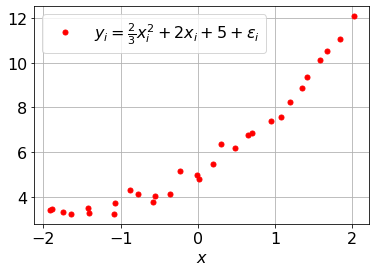

In [3]:
def f(vX):
    return 2/3 * vX**2 + 2*vX + 5

N  = 30
vX = np.linspace(-2, 2, N, endpoint=True) + np.random.randn(N) / 20   
vY = f(vX) + np.random.randn(N) / 3

#-- Plot:
plt.figure()
plt.plot(vX, vY, '.r', markersize=10, label=r'$y_i = \frac{2}{3}x_i^2 + 2x_i + 5 + \epsilon_i$')
plt.xlabel('$x$')
plt.legend()
plt.grid(True)
lAxis = plt.axis()

### Plot Lasso funciton:
$$\arg\min_{\boldsymbol{w},b}\left\Vert \boldsymbol{y}-\boldsymbol{\Phi}\boldsymbol{w}-b\right\Vert _{2}^{2}+\lambda\left\Vert \boldsymbol{w}\right\Vert _{1}$$
where:
$$\boldsymbol{\Phi}=\left[\begin{matrix}x_{1} & x_{1}^{2} & \cdots & x_{1}^{P}\\
x_{2} & x_{2}^{2} & \cdots & x_{2}^{P}\\
\vdots & \vdots &  & \vdots\\
x_{N} & x_{N}^{2} & \cdots & x_{N}^{P}
\end{matrix}\right]$$

In [4]:
from sklearn.linear_model  import Lasso
from sklearn.metrics       import r2_score
from sklearn.preprocessing import PolynomialFeatures

def PlotRegression(lam):
    P = 15

    if lam == 0:
        vW  = np.polyfit(vX, vY, P)
    else:
        #-- Apply Lasso:
#         mX   = np.c_[[vX**p for p in range(1, P+1)]].T
        mX   = PolynomialFeatures(degree=P, include_bias=False).fit_transform(vX[:,None])
        oMdl = Lasso(alpha=lam, fit_intercept=True, max_iter=20000).fit(mX, vY)
        vW   = np.r_[oMdl.coef_[::-1], oMdl.intercept_]
#         print(vW)

    #-- R2 score:
    vHatY = np.polyval(vW, vX)
    R2    = r2_score(vY, vHatY)
        
    #-- Plot:
    x = np.linspace(lAxis[0], lAxis[1], 1001)
    y = np.polyval(vW, x)

    _, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(vX, vY, '.r', markersize=10)
    ax[0].plot(x,  y,  'b',  lw=2)
    ax[0].axis(lAxis)
    ax[0].grid(True)
    ax[0].set_title(f'$\lambda = {lam}$\n$R^2 = {R2}$')
    
    ax[1].stem(vW[::-1], use_line_collection=True)
    ax[1].set_title('Coefficients')
    ax[1].set_xlabel('$w$')

### Increase Lasso regularization promotes sparsity:

In [5]:
from ipywidgets import interact, FloatSlider, Layout

lamSlider = FloatSlider(min=0, max=1, step=0.001, value=0, layout=Layout(width='80%'))
interact(PlotRegression, lam=lamSlider)
plt.show()

interactive(children=(FloatSlider(value=0.0, description='lam', layout=Layout(width='80%'), max=1.0, step=0.00…

### Exercise:
* Use the Boston house-prices dataset.
* Use cross-validation with $K=20$.
* Try to achieve the best R2 score you can.
* Hint 1:
    * Use `sklearn.preprocessing.PolynomialFeatures` to obtain polynomial features.
    * Use `sklearn.linear_model.LinearRegression` to compute a linear regressor model.
    * Use `cross_val_predict` instead of `cross_val_score` when performing regression.
* Hint 2: consider to normalize your features (and data),  
that is, zero mean and unit variance.

* Which value of $P$ provides the best result?  
Did you use regularization?

### Load the Boston house-prices dataset:

In [8]:
import sklearn.datasets

dData = sklearn.datasets.load_boston()
print(dData.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
mX = dData.data
vY = dData.target

mX.shape, vY.shape

((506, 13), (506,))

### Let us try regression (without regularization):

In [12]:
import pandas as pd

from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model    import LinearRegression

mX = mX - np.mean(mX, axis=0)
mX = mX / np.std(mX,  axis=0)

#-- Cross validation regression with Lasso:
dRes   = pd.DataFrame(columns=['P', 'R2'])
for P in [1, 2, 3]:
    mPhi                = PolynomialFeatures(P, include_bias=False).fit_transform(mX)
    mPhi                = mPhi - np.mean(mPhi, axis=0)
    mPhi[:,1:]          = mPhi[:,1:] / np.std(mPhi[:,1:], axis=0)
    vHatY               = cross_val_predict(LinearRegression(), mPhi, vY, cv=KFold(20, shuffle=True))
    dRes.loc[len(dRes)] = [P, r2_score(vY, vHatY)]

dRes.sort_values(by='R2', ascending=False)

,P,R2
1,2.0,8.406318e-01
0,1.0,7.235415e-01
2,3.0,-2.641390e+10


### Let us try regression (with regularization):

In [13]:
import pandas as pd

#-- Cross validation regression with Lasso:
vLam   = np.logspace(-2.2, -1, 15)
dRes   = pd.DataFrame(columns=['P', 'lam', 'R2'])
for P in [1, 2, 3]:
    for lam in vLam:
        mPhi                = PolynomialFeatures(P, include_bias=False).fit_transform(mX)
        mPhi                = mPhi - np.mean(mPhi, axis=0)
        mPhi                = mPhi / np.std(mPhi,  axis=0)
        vHatY               = cross_val_predict(Lasso(alpha=lam, max_iter=10000), mPhi, vY, cv=KFold(20, shuffle=True))
        dRes.loc[len(dRes)] = [P, lam, r2_score(vY, vHatY)]

dRes.sort_values(by='R2', ascending=False)

,P,lam,R2
36,3.0,0.020620,0.888895
37,3.0,0.025119,0.888699
35,3.0,0.016927,0.887537
38,3.0,0.030599,0.883055
34,3.0,0.013895,0.881731
40,3.0,0.045409,0.881324
39,3.0,0.037276,0.880485
41,3.0,0.055317,0.873873
18,2.0,0.011406,0.872479
16,2.0,0.007686,0.872095
